<a href="https://colab.research.google.com/github/Parv-Agarwal/Internship-project/blob/main/Pre_Trained_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import os

class MNISTDataset(Dataset):
    def __init__(self, file_name, max_load=None, transform=None):
        # Load the dataset from the given file
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data
        if 'train' in file_name:
            dataset = datasets.MNIST(root='./data', train=True, download=True)
        else:
            dataset = datasets.MNIST(root='./data', train=False, download=True)

        self.data = dataset.data
        self.labels = dataset.targets

        # Limit the number of examples if max_load is specified
        if max_load is not None and max_load > 0 and max_load < len(self.data):
            self.data = self.data[:max_load]
            self.labels = self.labels[:max_load]
            print(f'<mnist> loading only {max_load} examples')

        print('<mnist> done')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        # Convert tensor to PIL Image
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Return label as an integer
        return img, label


In [3]:
# dataset_mnistM.py

import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os
from torchvision import transforms

class MNISTMDataset(Dataset):
    def __init__(self, file_name, max_load=None, transform=None):
        # Load the MNIST-M dataset from the given file
        # Assuming the dataset is stored in .npy files or a custom format
        self.transform = transform
        self.data = []
        self.labels = []

        # Load data from file_name
        # For this example, we'll assume data is stored in .pt files
        # Replace this with the actual data loading code
        if not os.path.isfile(file_name):
            raise FileNotFoundError(f"File {file_name} not found.")

        data_dict = torch.load(file_name)

        # Check if data_dict is a tuple and convert to dict if needed
        if isinstance(data_dict, tuple):
            # Assuming the tuple has data and labels in the first two positions
            self.data = data_dict[0]
            self.labels = data_dict[1]
        else:
            self.data = data_dict['data']
            self.labels = data_dict['labels']

        n_example = self.data.size(0)
        print(f'nExample {n_example}')

        # Limit the number of examples if max_load is specified
        if max_load is not None and max_load > 0 and max_load < n_example:
            n_example = max_load
            print(f'<mnistM> loading only {n_example} examples')
            self.data = self.data[:n_example]
            self.labels = self.labels[:n_example]

        print('<mnistM> done')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8))
        elif torch.is_tensor(img):
            if img.dim() == 3:
                img = img.permute(2, 0, 1)
            elif img.dim() == 2:
                img = img.unsqueeze(0)
            img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        # Return label as an integer
        return img, label


In [4]:
opt = {
    'dataset': 'mnist',
    'batchSize': 64,
    'loadSize': 33,
    'fineSize': 32,
    'nz': 100,               # # of dim for Z
    'ngf': 64,               # # of gen filters in first conv layer
    'ndf': 64,               # # of discrim filters in first conv layer
    'nThreads': 4,           # # of data loading threads to use
    'niter': 10000,          # # of iter at starting learning rate
    'lr': 0.0002,            # initial learning rate for adam
    'beta1': 0.5,            # momentum term of adam
    'ntrain': float('inf'),  # # of examples per epoch
    'display': 0,            # display samples while training
    'display_id': 0,         # display window id
    'gpu': 1,                # gpu = 0 is CPU mode. gpu=X is GPU mode on GPU X
    'name': 'Logfiles',
    'noise': 'normal',       # 'uniform' or 'normal'
    'epoch_save_modulo': 1,
    'manual_seed': 4,        # Seed
    'nc': 3,                 # # of channels in input
    'save': 'logs/',         # Directory to save logs
    'data_root': './data',   # Root directory for datasets
    'lamda': 1,              # Lambda value for GRL
    'baseLearningRate': 0.0002,
    'max_epoch': 10000,
    'gamma': 0.001,
    'power': 0.75,
    'max_epoch_grl': 10000,
    'alpha': 10,
    'num_classes': 10,
    'num_epochs': 10,
    'image_size': 32,
}

train_gen_epoch = 25

In [5]:
# Set random seed
import random
random.seed(opt['manual_seed'])
torch.manual_seed(opt['manual_seed'])
torch.set_num_threads(1)

if torch.cuda.is_available() and opt['gpu'] > 0:
    torch.cuda.manual_seed_all(opt['manual_seed'])
    device = torch.device(f'cuda:{opt["gpu"] - 1}')
else:
    device = torch.device('cpu')

print(f"Random Seed: {opt['manual_seed']}")
print(f"Device: {device}")

# Initialize data loaders
transform_mnist = transforms.Compose([
    transforms.Resize(opt['fineSize']),
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])

transform_mnistM = transforms.Compose([
    transforms.Resize(opt['fineSize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Random Seed: 4
Device: cuda:0


In [6]:
mnist_train_path = 'mnist_train.pt'  # Adjust the path as needed
mnist_test_path = 'mnist_test.pt'    # Adjust the path as needed
max_train_load = None  # Set to None or an integer value
max_test_load = None   # Set to None or an integer value

mnist_train_dataset = MNISTDataset(mnist_train_path, max_load=max_train_load, transform=transform_mnist)
mnist_test_dataset = MNISTDataset(mnist_test_path, max_load=max_test_load, transform=transform_mnist)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=opt['batchSize'], shuffle=False, num_workers=opt['nThreads'])

print(f"MNIST Dataset: Size: {len(mnist_train_dataset)}")

# Load MNIST-M dataset
mnistm_train_path = 'mnist_m_train.pt'  # Adjust the path as needed
mnistm_test_path = 'mnist_m_test.pt'    # Adjust the path as needed
Num_Train_Target = 59001
Num_Test_Target = 10001

mnistm_train_dataset = MNISTMDataset(mnistm_train_path, max_load=Num_Train_Target, transform=transform_mnistM)
mnistm_test_dataset = MNISTMDataset(mnistm_test_path, max_load=Num_Test_Target, transform=transform_mnistM)

mnistm_train_loader = DataLoader(mnistm_train_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=opt['nThreads'])
mnistm_test_loader = DataLoader(mnistm_test_dataset, batch_size=opt['batchSize'], shuffle=False, num_workers=opt['nThreads'])

print(f"MNIST-M Dataset: Size: {len(mnistm_train_dataset)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18065227.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499166.35it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3842507.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7660043.73it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

<mnist> done
<mnist> done


<ipython-input-3-93bb4da21f49>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(file_name)


MNIST Dataset: Size: 60000
nExample 60000
<mnistM> loading only 59001 examples
<mnistM> done
nExample 10000
<mnistM> done
MNIST-M Dataset: Size: 59001


In [7]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z + one-hot class vector
            nn.ConvTranspose2d(nz + 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, num_classes):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc + num_classes) x 32 x 32
            nn.Conv2d(nc + num_classes, ndf, 4, 2, 1, bias=False),  # Output: (ndf) x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            # Continue with the rest of your layers as before
            nn.Conv2d(ndf, ndf * 4, 4, 2, 1, bias=False),  # Output: (ndf*4) x 8 x 8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # Output: (ndf*8) x 4 x 4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),  # Output: 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)


In [10]:
from torch.utils.data import ConcatDataset


combined_dataset = ConcatDataset([mnist_train_dataset, mnistm_train_dataset])
dataloader = DataLoader(combined_dataset, batch_size=opt['batchSize'], shuffle=True, num_workers=2)
netG = Generator(opt['nz'], opt['ngf'], opt['nc']).to(device)
netD = Discriminator(opt['nc'], opt['ndf'], opt['num_classes']).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt['lr'], betas=(opt['beta1'], 0.999))



In [11]:
for epoch in range(opt['num_epochs']):
    for i, (real_images, labels) in enumerate(dataloader):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        # Format batch
        real_images = real_images.to(device)
        labels = labels.long().to(device)
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size,), 1., device=device)
        fake_labels = torch.full((batch_size,), 0., device=device)

        # Create one-hot encoding of labels
        labels_one_hot = torch.nn.functional.one_hot(labels, opt['num_classes']).type(torch.float).to(device)
        labels_one_hot = labels_one_hot.unsqueeze(2).unsqueeze(3)
        labels_one_hot = labels_one_hot.expand(batch_size, opt['num_classes'], opt['image_size'], opt['image_size'])

        # Concatenate labels to images
        real_images_with_labels = torch.cat((real_images, labels_one_hot), 1)

        # Forward pass real batch through D
        output = netD(real_images_with_labels).view(-1)
        errD_real = criterion(output, real_labels)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, opt['nz'], 1, 1, device=device)
        # Generate random labels
        random_labels = torch.randint(0, opt['num_classes'], (batch_size,), device=device)
        random_labels_one_hot = torch.nn.functional.one_hot(random_labels, opt['num_classes']).type(torch.float).to(device)
        random_labels_one_hot_gen = random_labels_one_hot.unsqueeze(2).unsqueeze(3)
        # Concatenate noise and labels for generator
        noise_with_labels = torch.cat((noise, random_labels_one_hot_gen), 1)

        fake_images = netG(noise_with_labels)

        # Concatenate labels to fake images for discriminator
        random_labels_one_hot_disc = random_labels_one_hot.unsqueeze(2).unsqueeze(3)
        random_labels_one_hot_disc = random_labels_one_hot_disc.expand(batch_size, opt['num_classes'], opt['image_size'], opt['image_size'])
        fake_images_with_labels = torch.cat((fake_images.detach(), random_labels_one_hot_disc), 1)

        # Classify fake images with D
        output = netD(fake_images_with_labels).view(-1)
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        # We want D to think the fake images are real
        fake_images_with_labels = torch.cat((fake_images, random_labels_one_hot_disc), 1)
        output = netD(fake_images_with_labels).view(-1)
        errG = criterion(output, real_labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{opt['num_epochs']}] Batch [{i}/{len(dataloader)}] "
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

# Save the generator model
torch.save(netG.state_dict(), 'pre_trained_gan_weights.pth')

print("Training Finished.")

Epoch [1/10] Batch [0/1860] Loss_D: 1.3706 Loss_G: 1.7319 D(x): 0.4649 D(G(z)): 0.3820/0.2595
Epoch [1/10] Batch [100/1860] Loss_D: 0.0603 Loss_G: 5.1479 D(x): 0.9642 D(G(z)): 0.0111/0.0263
Epoch [1/10] Batch [200/1860] Loss_D: 0.2749 Loss_G: 3.9024 D(x): 0.8631 D(G(z)): 0.0748/0.0366
Epoch [1/10] Batch [300/1860] Loss_D: 0.6928 Loss_G: 2.7403 D(x): 0.8098 D(G(z)): 0.2798/0.0982
Epoch [1/10] Batch [400/1860] Loss_D: 0.5398 Loss_G: 3.2350 D(x): 0.8546 D(G(z)): 0.2517/0.0578
Epoch [1/10] Batch [500/1860] Loss_D: 0.3424 Loss_G: 3.5262 D(x): 0.8690 D(G(z)): 0.1509/0.0507
Epoch [1/10] Batch [600/1860] Loss_D: 0.5792 Loss_G: 2.9810 D(x): 0.8196 D(G(z)): 0.2495/0.0863
Epoch [1/10] Batch [700/1860] Loss_D: 0.7086 Loss_G: 2.3989 D(x): 0.6740 D(G(z)): 0.1623/0.1444
Epoch [1/10] Batch [800/1860] Loss_D: 0.4684 Loss_G: 1.8805 D(x): 0.7661 D(G(z)): 0.1229/0.2268
Epoch [1/10] Batch [900/1860] Loss_D: 0.5392 Loss_G: 2.6484 D(x): 0.8400 D(G(z)): 0.2157/0.1152
Epoch [1/10] Batch [1000/1860] Loss_D: 0.6

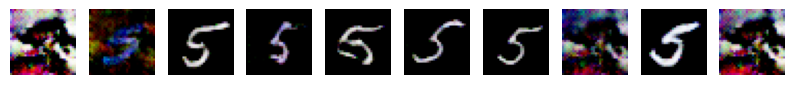

In [14]:
import torch
import matplotlib.pyplot as plt

# Set the generator to evaluation mode
netG.eval()

# Define the label for which you want to generate MNIST-M images (e.g., 5)
test_label = 5
num_samples = 10  # Number of images to generate

# Generate random noise
noise = torch.randn(num_samples, opt['nz'], 1, 1, device=device)

# Create one-hot encoding of the test label
test_label_tensor = torch.tensor([test_label] * num_samples, device=device)
test_label_one_hot = torch.nn.functional.one_hot(test_label_tensor, opt['num_classes']).type(torch.float).to(device)
test_label_one_hot_gen = test_label_one_hot.unsqueeze(2).unsqueeze(3)

# Concatenate the noise and the label
noise_with_labels = torch.cat((noise, test_label_one_hot_gen), 1)

# Generate fake MNIST-M images
with torch.no_grad():  # No need to track gradients during inference
    fake_images = netG(noise_with_labels).cpu()

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    # Assuming MNIST-M images are RGB, we use transpose to convert the generated tensor to (H, W, C)
    axes[i].imshow(fake_images[i].permute(1, 2, 0))  # permute to (height, width, channels) for RGB
    axes[i].axis('off')

plt.show()

